Poggio Civitate, situated in Siena, Italy, stands as an archaeological testament to the ancient Etruscan Civilization, with excavation efforts initiated in the mid-1960s. Through decades of meticulous excavation, a comprehensive database has been amassed, cataloging the myriad artifacts unearthed from this historical enclave. In this notebook, our focus lies in harnessing the power of data visualizations to elucidate the distribution patterns of metal artifacts within this ancient settlement. By employing visualization techniques, we endeavor to discern underlying trends and patterns, aiming to unveil insights into the societal dynamics and potential hierarchies prevalent amongst the inhabitants who dwelled in this settlement over two millennia ago. Thus, the overarching question guiding our exploration is: How can we extract useful and meaningful information by leveraging data visualizations?

First, let's install all of the packages that we need to map this data. This may take a few minutes to run.

Now we need to connect Google Drive

In [ ]:
!sudo apt-get install gnupg software-properties-common
!sudo apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 51F523511C7028C3
!sudo add-apt-repository "deb https://qgis.org/debian-ltr/ `lsb_release -c -s` main"
!sudo apt-get update
!sudo apt-get install opencl-headers ocl-icd-opencl-dev
!sudo apt-get install qgis python3-qgis qgis-plugin-grass
!python -m pip install rasterio gdal
!python -m pip install geopandas
!python -m pip install contextily

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
gnupg is already the newest version (2.2.27-3ubuntu2.1).
gnupg set to manually installed.
software-properties-common is already the newest version (0.99.22.9).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Executing: /tmp/apt-key-gpghome.GKp3KCHbAy/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 51F523511C7028C3
gpg: key 51F523511C7028C3: public key "QGIS Archive Automatic Signing Key (2019) <qgis-developer@lists.osgeo.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Repository: 'deb https://qgis.org/debian-ltr/ jammy main'
Description:
Archive for codename: jammy components: main
More info: https://qgis.org/debian-ltr/
Adding repository.
Press [ENTER] to continue or Ctrl-c to cancel.
Adding deb entry to /etc/apt/sources.list.d/archive_uri-https_qgis_org_debian-ltr_-jammy.list
Adding disabled deb-src entry to /etc/apt/sources.list.d/archiv

In [ ]:
# imports the drive library and mounts your Google Drive as a VM local drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Import the csv file containing all metal artifacts found at Poggio Civitate.

In [ ]:
import pandas as pd

# Read the CSV file
df = pd.read_csv("metals.csv")

In this notebook, we will be exploring the distribution of metal artifacts found at Poggio Civitate with the hopes of identifying any underlying trends or patterns that exist within the data. To do this, let's create a function that separates each artifact by the type of metal that it contains, and then plot this data.

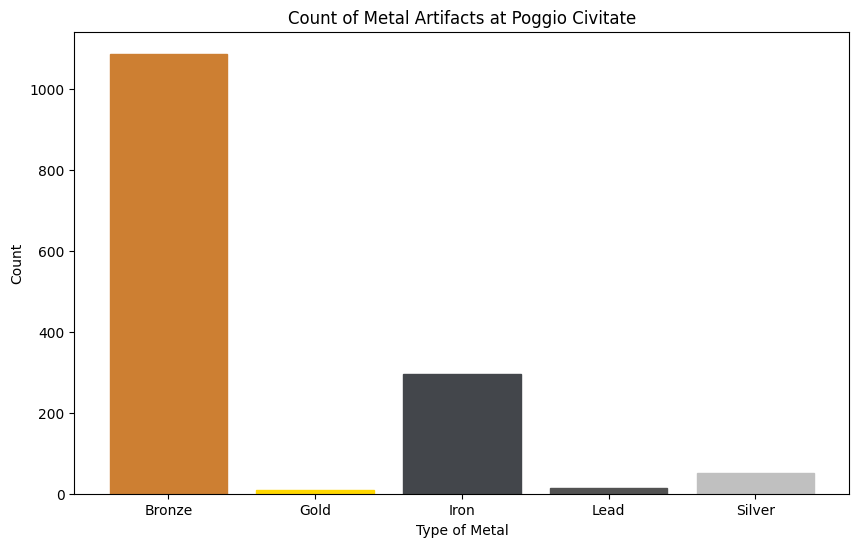

In [ ]:
import matplotlib.pyplot as plt


# Split observations with multiple words
df = df.assign(Fabric_Description=df['Fabric Description'].str.split(', ')).explode('Fabric_Description')

# Define a function to categorize the fabric types
def categorize_fabric_type(description):
    if pd.isnull(description):
        return 'Other'
    if 'gold' in description.lower():
        return 'Gold'
    elif 'silver' in description.lower():
        return 'Silver'
    elif 'iron' in description.lower():
        return 'Iron'
    elif 'lead' in description.lower():
        return 'Lead'
    elif 'bronze' in description.lower():
        return 'Bronze'
    else:
        return 'Other'

# Apply the function to create a new column 'Fabric_Type'
df['Fabric_Type'] = df['Fabric_Description'].apply(categorize_fabric_type)

# Group by 'Fabric_Type' and count the occurrences
df_counts = df.groupby('Fabric_Type').size().reset_index(name='count')

# Exclude the 'Other' category
df_counts = df_counts[df_counts['Fabric_Type'] != 'Other']

# Define colors for each fabric type
colors = {
    'Gold': '#FFD700',   # Gold
    'Silver': '#C0C0C0', # Silver
    'Iron': '#43464B',    # Iron
    'Lead': '#525252',    # Lead
    'Bronze': '#CD7F32'   # Bronze
}

# Create the bar plot with color-coded bars
plt.figure(figsize=(10, 6))
bars = plt.bar(df_counts['Fabric_Type'], df_counts['count'])
for bar, fabric_type in zip(bars, df_counts['Fabric_Type']):
    bar.set_color(colors.get(fabric_type, 'black'))
plt.xlabel('Type of Metal')
plt.ylabel('Count')
plt.title('Count of Metal Artifacts at Poggio Civitate')
plt.show()

As you can see, bronze is clearly the most common metal found at this site. Now that we know the frequency of the five types of metals that we are interested in, lets map the locations of these artifacts to see if there are any underlying patterns.

In [ ]:
#QGIS

!export PYTHONPATH="/usr/share/qgis/python"
!export LD_LIBRARY_PATH="/usr/lib/qgis"
!export QGIS_PREFIX="/usr"

import os
from osgeo import ogr
from qgis.core import *
from qgis.analysis import *
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

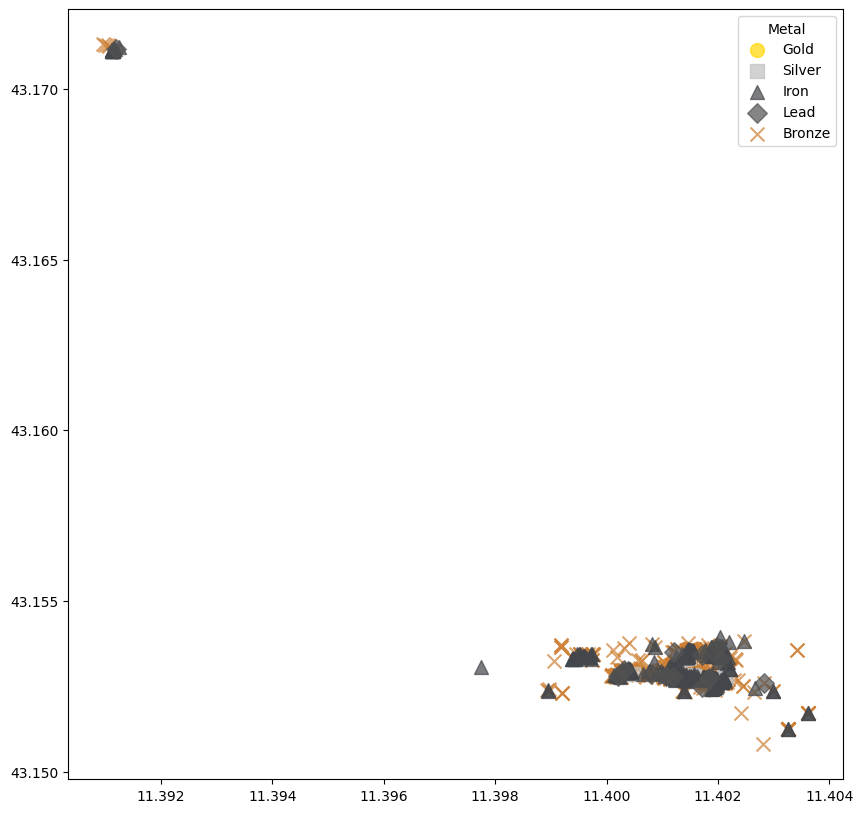

In [ ]:
# Define markers for each metal type
markers = {
    'Gold': 'o',   # Circle marker
    'Silver': 's', # Square marker
    'Iron': '^',    # Triangle_up marker
    'Lead': 'D',    # Diamond marker
    'Bronze': 'x'   # X marker
}

# Convert DataFrame to GeoDataFrame
geometry = [Point(xy) for xy in zip(df['Longitude (WGS 84)'], df['Latitude (WGS 84)'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')

# Plot the GeoDataFrame with markers and colors based on metal type
fig, ax = plt.subplots(figsize=(10, 10))

# Plot all metals except Bronze
for metal in markers.keys():
    if metal != 'Bronze':
        gdf_metal = gdf[gdf['Fabric_Type'] == metal]
        ax.scatter(gdf_metal.geometry.x, gdf_metal.geometry.y, color=colors[metal], marker=markers[metal], label=metal, s=100, alpha=0.7)

# Plot Bronze with lower z-order to be behind other points
gdf_bronze = gdf[gdf['Fabric_Type'] == 'Bronze']
ax.scatter(gdf_bronze.geometry.x, gdf_bronze.geometry.y, color=colors['Bronze'], marker=markers['Bronze'], label='Bronze', s=100, alpha=0.7, zorder=-1)

plt.legend(title='Metal')
plt.show()

This map is a good start, but it is very hard to differentiate metals due to significant overlap. Let's try plotting each metal separately and get rid of any outliers in our data.

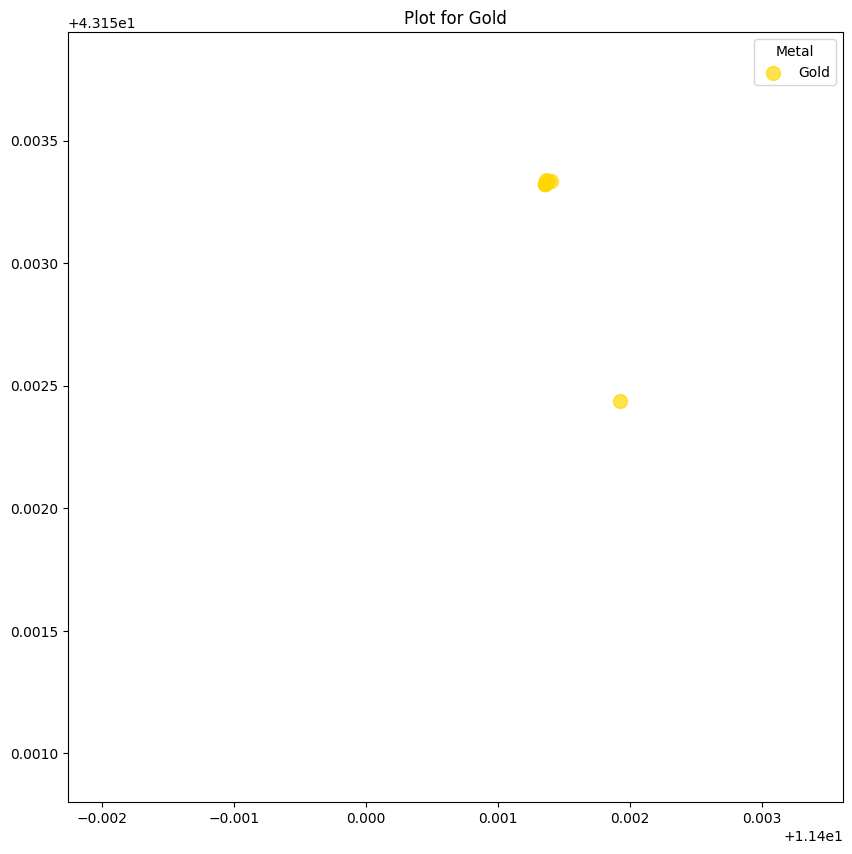

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy as np

# Filter GeoDataFrame to exclude points west of 11.397 or north of 43.1550
gdf_filtered = gdf[(gdf.geometry.x >= 11.397) & (gdf.geometry.y <= 43.1550)]

# Get the maximum range for x and y coordinates
x_min, y_min, x_max, y_max = gdf_filtered.total_bounds
x_range = x_max - x_min
y_range = y_max - y_min

# Create a list of metal types
metal_types = list(markers.keys())

fig, ax = plt.subplots(figsize=(10, 10))

def update_plot(frame):
    ax.clear()
    metal = metal_types[frame]
    gdf_metal = gdf_filtered[gdf_filtered['Fabric_Type'] == metal]
    ax.scatter(gdf_metal.geometry.x, gdf_metal.geometry.y, color=colors[metal], marker=markers[metal], label=metal, s=100, alpha=0.7)
    ax.legend(title='Metal')
    ax.set_title(f'Plot for {metal}')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

# Create an animation
num_frames = len(metal_types)
ani = FuncAnimation(fig, update_plot, frames=num_frames, interval=500, repeat=False)

# Display the animation
HTML(ani.to_jshtml())


Great! Now let's insert a basemap behind this geospatial data.

In [1]:
import contextily as ctx  # Import contextily for basemaps

def update_plot(frame):
    ax.clear()
    metal = metal_types[frame]
    gdf_metal = gdf_filtered[gdf_filtered['Fabric_Type'] == metal]
    ax.scatter(gdf_metal.geometry.x, gdf_metal.geometry.y, color=colors[metal], marker=markers[metal], label=metal, s=100, alpha=0.7)
    ax.legend(title='Metal')
    ax.set_title(f'Plot for {metal}')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=gdf.crs)



# Create an animation
num_frames = len(metal_types)
ani = FuncAnimation(fig, update_plot, frames=num_frames, interval=1000, repeat=False)

# Display the animation
HTML(ani.to_jshtml())

ModuleNotFoundError: No module named 'contextily'

In the animation provided, it is evident that the more prevalent metals such as bronze, iron, and lead are distributed extensively throughout Poggio Civitate, with a noticeable concentration towards the central region, forming an inverted "T" pattern mirroring the layout of the former structures. Conversely, the scarcer metals, notably silver and gold, are confined exclusively within the confines of the erstwhile architectural edifices. From an external perspective, this observation suggests that the individuals within this ancient society assigned greater value to the rarer metals, given their containment within these historical structures.